### Image classification using Fashion MNIST data set
#### This notebook investigates whether multiple CNN models can achieve higher classification accuracy than any individual model. Two simple strategies for combining models are examined:

> 1.   Classification based on the average class probabilities of models

> 2.   Using the mode class for prediction

In [0]:
# Import
import os # for file handling
import pandas as pd # for data handling
import numpy as np # for linear algebra
import time # to time runs


In [0]:
import matplotlib.pyplot as plt # to display images
from sklearn import metrics # to evaluate classification accuracy
import tensorflow as tf # for neural networks

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout

#### Get data

In [4]:
# get fashion mnist data
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

# show shapes of tensors
print("x_train shape:", x_train.shape, ", y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape, ", y_test shape:", y_test.shape)

# get number of classes
nClasses = len(np.unique(y_train)) # number of output classes
print("Number of classes: ", nClasses)

4423680/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) , y_train shape: (60000,)
x_test shape: (10000, 28, 28) , y_test shape: (10000,)
Number of classes:  10


#### Pre-process data

In [5]:
# normalize grayscale pixel values (0-255) to (0,1)
x_train = x_train.astype('float32')/255 # normalized training inputs
x_test = x_test.astype('float32')/255 # normalized test inputs

# reshape to needed input shape for network
x_train, x_test = x_train.reshape((-1,28,28,1)), x_test.reshape((-1,28,28,1))
input_shape = x_train.shape[1:] # input shape for network

# show shapes of re-shaped tensors
print("x_train shape:", x_train.shape, ", y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape, ", y_test shape:", y_test.shape)

# get image dimensions
img_h, img_w, img_channels = x_train.shape[1:] # size of image
print("Image height = %d, image width = %d, number of channels = %d" 
      %(img_h, img_w, img_channels))

x_train shape: (60000, 28, 28, 1) , y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1) , y_test shape: (10000,)
Image height = 28, image width = 28, number of channels = 1


#### Define function to create Convolution Neural Network

In [0]:
def convNN(model, ch1, ch2, kernel, pool, nDense, drop, dropDense):
    
    model = tf.keras.models.Sequential() # create model                
    
    # first CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(ch1, kernel, padding="same", 
                     activation="relu", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(ch1, kernel, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool))
    model.add(tf.keras.layers.Dropout(drop))
 
    # second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(ch2, kernel, padding="same", 
                     activation="relu", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(ch2, kernel, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool))
    model.add(tf.keras.layers.Dropout(drop))
 
    model.add(tf.keras.layers.Flatten()) 
    
    # FC => RELU layers
    model.add(tf.keras.layers.Dense(nDense, activation='relu'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropDense))
    
    # output softmax layer
    model.add(tf.keras.layers.Dense(nClasses, activation='softmax'))
    
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
 
    return model

#### Specify parameters for convolution network

In [8]:
# Parameters for CNN models (change as desired)
ch1, ch2 = 32, 64 # number of output channels
kernel = (3,3) # filter shape
pool = (2,2) # max pool size
nDense = 512 # dense layer size
drop, dropDense = 0.25, 0.5

# create model
mod = convNN('model', ch1, ch2, kernel, pool, nDense, drop, dropDense)
mod.summary() # show model summary

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)    

#### Define function to plot accuracy with training and validation data 

In [0]:
def plotHistorty(model, history):
    # plot history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(model+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### Specify parameters for training

In [0]:
batchSize = 32 # batch size for training
epochs = 100 # number of training epochs

#### Train CNN models


Training Model: model_1

Train on 50000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.4945 - acc: 0.8321
Epoch 00001: val_acc improved from -inf to 0.89430, saving model to model_1.weights.hdf5
50000/50000 [==============================] - 32s 642us/sample - loss: 0.4941 - acc: 0.8322 - val_loss: 0.2839 - val_acc: 0.8943
Epoch 2/100
49952/50000 [============================>.] - ETA: 0s - loss: 0.3118 - acc: 0.8888
Epoch 00002: val_acc improved from 0.89430 to 0.90800, saving model to model_1.weights.hdf5
50000/50000 [==============================] - 28s 558us/sample - loss: 0.3119 - acc: 0.8888 - val_loss: 0.2696 - val_acc: 0.9080
Epoch 3/100
49952/50000 [============================>.] - ETA: 0s - loss: 0.2718 - acc: 0.9035
Epoch 00003: val_acc improved from 0.90800 to 0.91590, saving model to model_1.weights.hdf5
50000/50000 [==============================] - 28s 558u

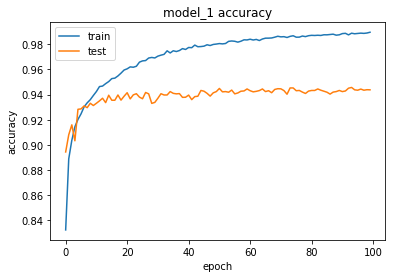


Training Model: model_2

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
49984/50000 [============================>.] - ETA: 0s - loss: 0.4889 - acc: 0.8341
Epoch 00001: val_acc improved from -inf to 0.90010, saving model to model_2.weights.hdf5
50000/50000 [==============================] - 31s 616us/sample - loss: 0.4888 - acc: 0.8342 - val_loss: 0.2766 - val_acc: 0.9001
Epoch 2/100
49984/50000 [============================>.] - ETA: 0s - loss: 0.3145 - acc: 0.8880
Epoch 00002: val_acc improved from 0.90010 to 0.91840, saving model to model_2.weights.hdf5
50000/50000 [==============================] - 29s 575us/sample - loss: 0.3144 - acc: 0.8881 - val_loss: 0.2306 - val_acc: 0.9184
Epoch 3/100
49952/50000 [============================>.] - ETA: 0s - loss: 0.2701 - acc: 0.9055
Epoch 00003: val_acc did not improve from 0.91840
50000/50000 [==============================] - 29s 574us/sample - loss: 0.2702 - acc: 0.9054 - val_loss: 0.2671 - val_acc: 0.9055
Epoch 4/100
499

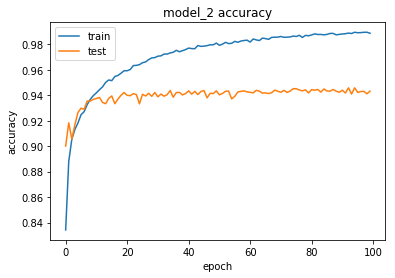


Training Model: model_3

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.4950 - acc: 0.8342
Epoch 00001: val_acc improved from -inf to 0.89880, saving model to model_3.weights.hdf5
50000/50000 [==============================] - 31s 612us/sample - loss: 0.4948 - acc: 0.8343 - val_loss: 0.2880 - val_acc: 0.8988
Epoch 2/100
49984/50000 [============================>.] - ETA: 0s - loss: 0.3119 - acc: 0.8890
Epoch 00002: val_acc improved from 0.89880 to 0.90980, saving model to model_3.weights.hdf5
50000/50000 [==============================] - 28s 564us/sample - loss: 0.3119 - acc: 0.8890 - val_loss: 0.2443 - val_acc: 0.9098
Epoch 3/100
49984/50000 [============================>.] - ETA: 0s - loss: 0.2744 - acc: 0.9026
Epoch 00003: val_acc improved from 0.90980 to 0.91870, saving model to model_3.weights.hdf5
50000/50000 [==============================] - 28s 565us/sample - loss: 0.2745 - acc: 0.9026 - val_loss

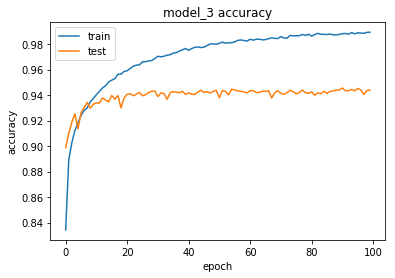

In [11]:
nModels = 3 # number of models to train
probs = np.zeros((len(y_test), nClasses)) # mean probabilities for classes
result = [] # for results

# Train models
for i in range(nModels):
    model = 'model_'+str(i+1) # model name
    print('\nTraining Model: '+ model + '\n')
    bestWts = model+".weights.hdf5" # best weights file
  
  # checkpoint to save best model
    checkpoint = tf.keras.callbacks.ModelCheckpoint(bestWts,
                                                  monitor='val_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode='max')
  
  # create model
    mod = convNN(model, ch1, ch2, kernel, pool, nDense, drop, dropDense)
  
    st = time.time() # start time for training
  
  # train models and maintain history
    hist = mod.fit(x_train,
                 tf.keras.utils.to_categorical(y_train, num_classes=nClasses), 
                 batch_size=batchSize,
                 epochs=epochs, 
                 validation_split = 1/6,
                 callbacks=[checkpoint])
    t = time.time() - st # time to train model
  
    print("\nTime to train classifier: %4.2f seconds\n" %(t))
  
    mod.save_weights(bestWts) # save best weights

    prob = mod.predict(x_test) # predict probabilities for test examples
    predicted = prob.argmax(axis=1) # most likely class
    acc = metrics.accuracy_score(y_test, predicted) # best accuracy 
    print('%s Test accuracy = %4.2f%%\n\n' %(model, acc*100.0))
  
    probs += prob
    predicted = probs.argmax(axis=1) # most likely class
    accCum = metrics.accuracy_score(y_test, predicted) # best accuracy 
    print('%s Gestalt Test accuracy = %4.2f%%\n\n' %(model,accCum*100.0))
  
    result.append([model,acc,accCum,t])
    plotHistorty(model, hist) # display training and test accuracy

#### Show results on model accuracy, cumulative accuracy, and training time

In [12]:
result = pd.DataFrame(result, 
                      columns=['model', 'accuracy', 'cum. accuracy', 'time'])
result

,model,accuracy,cum. accuracy,time
0,model_1,0.9380,0.9380,2810.556279
1,model_2,0.9374,0.9411,2832.492863
2,model_3,0.9390,0.9434,2838.253579


#### specify label for classes

In [0]:
items = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
         'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # labels
item = dict(zip(range(10), items)) # create dictionary mapping class to labels

#### Show confusion matrix

In [14]:
cm = metrics.confusion_matrix(y_test, predicted)
cm = pd.DataFrame(cm, columns=items)
cm.insert(0,"True",items)
cm

,True,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,T-shirt/top,878,0,18,11,2,1,89,0,1,0
1,Trouser,2,989,0,6,0,0,2,0,1,0
2,Pullover,11,1,930,5,27,0,26,0,0,0
3,Dress,9,0,6,948,22,0,15,0,0,0
4,Coat,1,0,19,15,936,0,29,0,0,0
5,Sandal,0,0,0,0,0,990,0,9,0,1
6,Shirt,69,0,37,22,52,0,816,0,4,0
7,Sneaker,0,0,0,0,0,2,0,986,0,12
8,Bag,3,1,0,4,0,1,1,0,990,0
9,Ankle boot,0,0,0,0,0,1,0,27,1,971


#### Show classification report

In [15]:
print(metrics.classification_report([items[i] for i in y_test], 
                                    [items[i] for i in predicted]))

              precision    recall  f1-score   support

  Ankle boot       0.99      0.97      0.98      1000
         Bag       0.99      0.99      0.99      1000
        Coat       0.90      0.94      0.92      1000
       Dress       0.94      0.95      0.94      1000
    Pullover       0.92      0.93      0.93      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.83      0.82      0.83      1000
     Sneaker       0.96      0.99      0.98      1000
 T-shirt/top       0.90      0.88      0.89      1000
     Trouser       1.00      0.99      0.99      1000

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



#### Use mode class for prediction

In [16]:
predClass = pd.DataFrame()
for i in range(nModels):
  model = 'model_'+str(i+1)
  print("processing " + model)
  bestWts = model+".weights.hdf5" # best weights file
  mod.load_weights(bestWts) # load best weights
  prob = mod.predict(x_test) # predict probabilities for test examples
  predClass[model] = prob.argmax(axis=1) # mst likely class
  
modeClass = predClass.mode(axis=1)
modeAcc = metrics.accuracy_score(y_test, modeClass[0])
print("Accuracy based on mode class = %4.2f%%" %(100.0*modeAcc))

processing model_1
processing model_2
processing model_3
Accuracy based on mode class = 94.30%


#### Compare accuracy for easy and hard classes
- Note that 'T-shirt/top', 'Pullover', 'Coat', and  'Shirt' are harder to classify than other items

In [17]:
hardClasses = [0,2,4,6] # classes with low classification accuracy
hardIndxTest = [i for i in range(len(y_test)) if y_test[i] in hardClasses]
easyIndxTest = [i for i in range(len(y_test)) if y_test[i] not in hardClasses]
print('Test data contains %d hard and %d easy examples' 
      %(len(hardIndxTest), len(easyIndxTest)))

accEasy = metrics.accuracy_score(y_test[easyIndxTest], predicted[easyIndxTest])
accHard = metrics.accuracy_score(y_test[hardIndxTest], predicted[hardIndxTest])

print('Test accuracy with easy examples = %4.2f%%' %(100.0*accEasy)) 
print('Test accuracy with hard examples = %4.2f%%' %(100.0*accHard)) 

Test data contains 4000 hard and 6000 easy examples
Test accuracy with easy examples = 97.90%
Test accuracy with hard examples = 89.00%


#### Observations:

1.   A simple CNN can achieve classification accuracy of over 93%
2.   Combining 3 models improves accuracy around 94.4%

1. It takes around 16 seconds per epoch using Colaboratory GPU accelerator and Test accuracy does not improve significantly after the first 20 epochs

1.   Combining a few more models trained over 20 epochs may further improve classification accuracy in a resonable amount of time.

1.   Classification accuracy is significantly lower for 4 classes: 'T-shirt/top', 'Pullover', 'Coat', and 'Shirt' 



#### Opportunities for improvement:


1.   Devise alternate methods for combining models
2.   Increase the diversity of constituent models

1.   Introduce regularization methods that prevent over-fitting beyond 20 epochs
2.   Develop a two-phased approach:  Predict using a combination of models in the first phase and use a separate model to re-classify examples predicted as 'T-shirt/top', 'Pullover', 'Coat', or 'Shirt












